# DATA 410 Lecture 8 - Spring 2021

<font face="Chalkboard" color="darkgreen" size=10> Univariate vs Multivariate Models</font>

## Univariate Models

How can we define univariate?

We have only one input variable. In short, the goal is to estimate an expectation:

$$ \mathbb{E}(y)=F(x)$$

where $x$ is univariate.

In [ ]:
# This is important: update the statsmodels package
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

In [1]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [4]:
# Tricubic Kernel
def tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>2,0,np.exp(-1/2*x**2))

In [5]:
#Defining the kernel local regression model

def lowess_kern(x, y, kern, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))

    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the kernel function by using only the train data    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

def model_lowess(dat_train,dat_test,kern,tau):
  dat_train = dat_train[np.argsort(dat_train[:, 0])]
  dat_test = dat_test[np.argsort(dat_test[:, 0])]
  Yhat_lowess = lowess_kern(dat_train[:,0],dat_train[:,1],kern,tau)
  datl = np.concatenate([dat_train[:,0].reshape(-1,1),Yhat_lowess.reshape(-1,1)], axis=1)
  f = interp1d(datl[:,0], datl[:,1],fill_value='extrapolate')
  return f(dat_test[:,0])

In [6]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Boston Housing Prices.csv')
df

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Winthrop,1801,-70.986000,42.231201,0.06263,0.0,11.93,no,0.573,6.593,69.099998,2.4786,1,273,21.000000,9.67,22.400000
502,Winthrop,1802,-70.990997,42.227501,0.04527,0.0,11.93,no,0.573,6.120,76.699997,2.2875,1,273,21.000000,9.08,20.600000
503,Winthrop,1803,-70.994797,42.226002,0.06076,0.0,11.93,no,0.573,6.976,91.000000,2.1675,1,273,21.000000,5.64,23.900000
504,Winthrop,1804,-70.987503,42.223999,0.10959,0.0,11.93,no,0.573,6.794,89.300003,2.3889,1,273,21.000000,6.48,22.000000


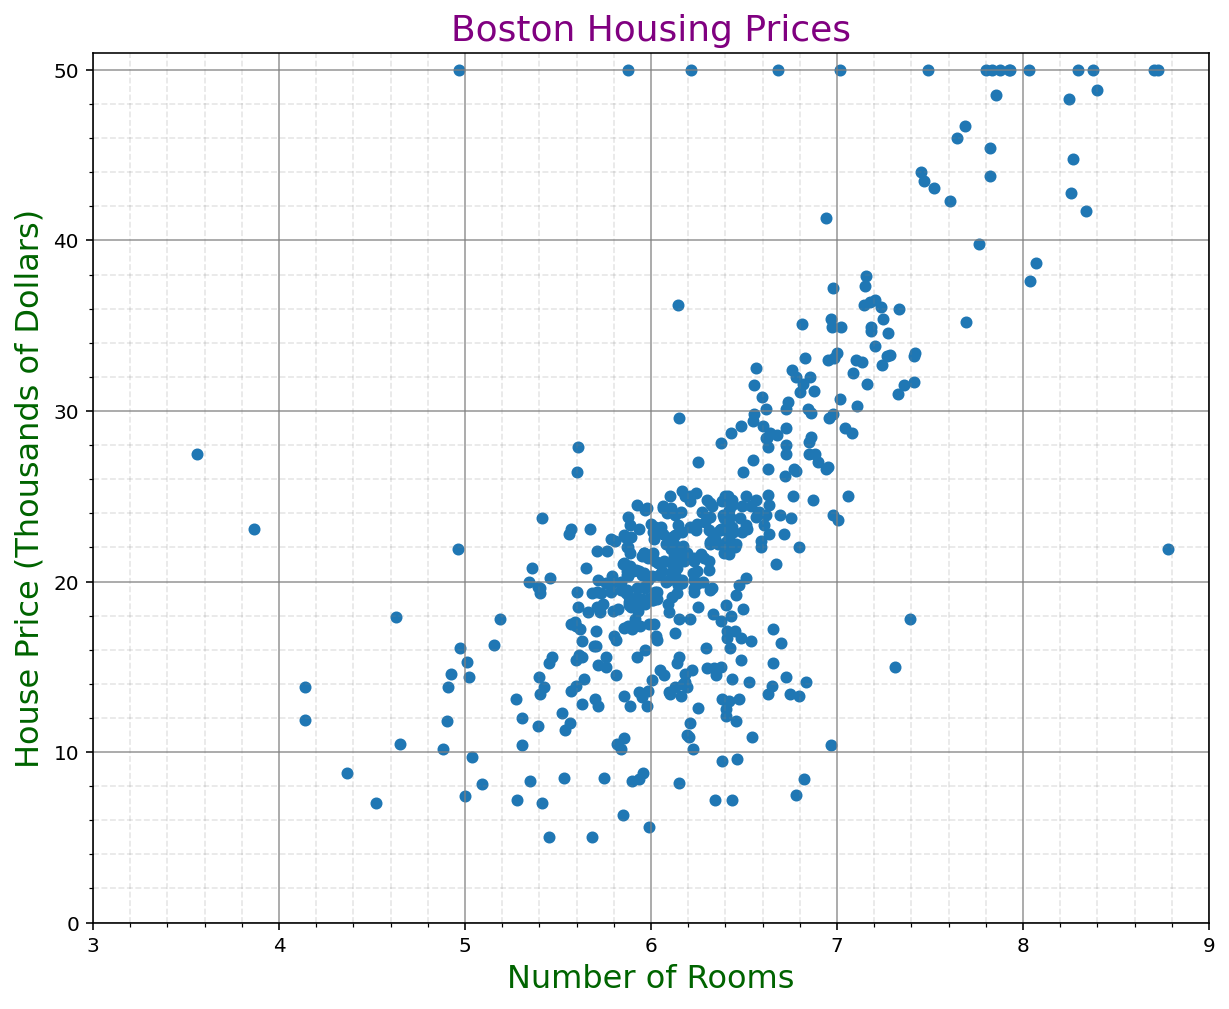

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [8]:
X = np.array(df['rooms']).reshape(-1,1)
y = np.array(df['cmedv']).reshape(-1,1)
dat = np.concatenate([X,y.reshape(-1,1)], axis=1)

In [40]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=2021)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

dat_train = np.concatenate([X_train,y_train.reshape(-1,1)], axis=1)
dat_train = dat_train[np.argsort(dat_train[:, 0])]

dat_test = np.concatenate([X_test,y_test.reshape(-1,1)], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]

In [10]:
kern = Gaussian


In [ ]:
dat_test

## Neural Network Approach

In [12]:
# imports for creating a Neural Networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [42]:
# Create a Neural Network model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=1))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400)

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=100, verbose=0, callbacks=[es])

# Calculate predictions
#yhat_nn = model.predict(X_test)

## Here are the predictions we made for the test data:

In [43]:
from sklearn.metrics import mean_absolute_error

yhat_nn = model.predict(dat_test[:,0])
mae_nn = mean_absolute_error(dat_test[:,1], yhat_nn)
print("MAE Neural Network = ${:,.2f}".format(1000*mae_nn))

MAE Neural Network = $3,858.97


In [44]:
yhat_lr = model_lowess(dat_train,dat_test,Gaussian,0.25)
mae_nn = mean_absolute_error(dat_test[:,1], yhat_lr)
print("MAE Kernel Weighted Regression = ${:,.2f}".format(1000*mae_nn))

MAE Kernel Weighted Regression = $3,763.59


In [46]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

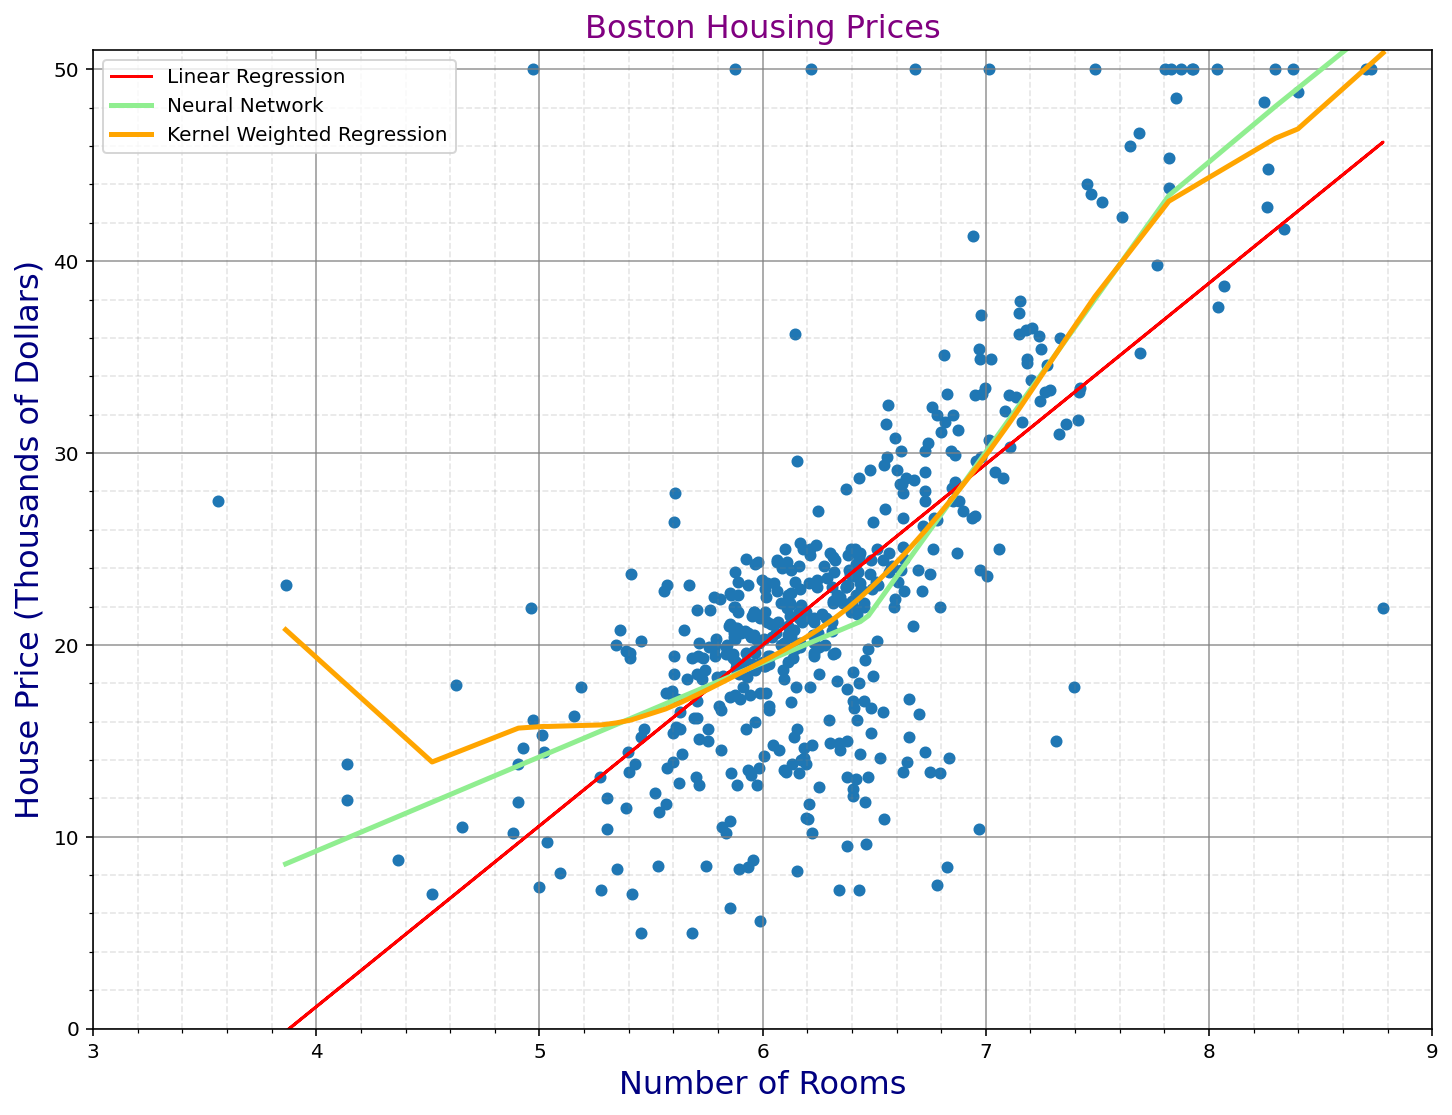

In [47]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.plot(X_test, lm.predict(X_test), color='red',label='Linear Regression')
ax.plot(dat_test[:,0], yhat_nn, color='lightgreen',lw=2.5,label='Neural Network')
ax.plot(dat_test[:,0], model_lowess(dat_train,dat_test,Quartic,0.45), color='orange',lw=2.5,label='Kernel Weighted Regression')
ax.set_xlabel('Number of Rooms',fontsize=16,color='navy')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='navy')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.legend()

In [27]:
from sklearn.model_selection import KFold

In [28]:
kf = KFold(n_splits=10, shuffle=True, random_state=1693)

In [29]:
mae_lm = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  lm.fit(X_train.reshape(-1,1),y_train)
  yhat_lm = lm.predict(X_test.reshape(-1,1))
  mae_lm.append(mean_absolute_error(y_test, yhat_lm))
print("Validated MAE Linear Regression = ${:,.2f}".format(1000*np.mean(mae_lm)))

Validated MAE Linear Regression = $4,447.94


In [31]:
%%timeit -n 1

mae_lk = []

for idxtrain, idxtest in kf.split(dat):
  dat_test = dat[idxtest,:]
  y_test = dat_test[np.argsort(dat_test[:, 0]),1]
  yhat_lk = model_lowess(dat[idxtrain,:],dat[idxtest,:],Gaussian,0.25)
  mae_lk.append(mean_absolute_error(y_test, yhat_lk))
print("Validated MAE Local Kernel Regression = ${:,.2f}".format(1000*np.mean(mae_lk)))

Validated MAE Local Kernel Regression = $4,110.76
Validated MAE Local Kernel Regression = $4,110.76
Validated MAE Local Kernel Regression = $4,110.76
1 loop, best of 3: 511 ms per loop


In [32]:
%%timeit -n 1

mae_nn = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  model.fit(X_train.reshape(-1,1),y_train,validation_split=0.3, epochs=1000, batch_size=100, verbose=0, callbacks=[es])
  yhat_nn = model.predict(X_test.reshape(-1,1))
  mae_nn.append(mean_absolute_error(y_test, yhat_nn))
print("Validated MAE Neural Network Regression = ${:,.2f}".format(1000*np.mean(mae_nn)))

Epoch 00651: early stopping
Epoch 00299: early stopping
Epoch 00290: early stopping
Epoch 00450: early stopping
Epoch 00429: early stopping
Epoch 00298: early stopping
Epoch 00416: early stopping
Epoch 00426: early stopping
Epoch 00423: early stopping
Epoch 00302: early stopping
Validated MAE Neural Network Regression = $4,170.68
Epoch 00336: early stopping
Epoch 00398: early stopping
Epoch 00215: early stopping
Epoch 00352: early stopping
Epoch 00288: early stopping
Epoch 00367: early stopping
Epoch 00222: early stopping
Epoch 00216: early stopping
Epoch 00681: early stopping
Epoch 00243: early stopping
Validated MAE Neural Network Regression = $4,133.27
Epoch 00237: early stopping
Epoch 00211: early stopping
Epoch 00426: early stopping


KeyboardInterrupt: ignored

## XGBoost

The method is related to Random Forest

https://towardsdatascience.com/xgboost-python-example-42777d01001e

In [ ]:
import xgboost as xgb

In [ ]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)

In [ ]:
%%timeit -n 1

mae_xgb = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  model_xgb.fit(X_train.reshape(-1,1),y_train)
  yhat_xgb = model_xgb.predict(X_test.reshape(-1,1))
  mae_xgb.append(mean_absolute_error(y_test, yhat_xgb))
print("Validated MAE XGBoost Regression = ${:,.2f}".format(1000*np.mean(mae_xgb)))

Validated MAE XGBoost Regression = $4,141.61
Validated MAE XGBoost Regression = $4,141.61
Validated MAE XGBoost Regression = $4,141.61
1 loop, best of 3: 321 ms per loop


## Using Kernel Regression from StatsModels

In [33]:
from statsmodels.nonparametric.kernel_regression import KernelReg

dat       = dat[np.argsort(dat[:, 0])]
model_KernReg = KernelReg(endog=dat_train[:,1],exog=dat_train[:,0],var_type='c',ckertype='gaussian')

In [48]:
yhat_sm, y_std = model_KernReg.fit(dat_train[:,0])

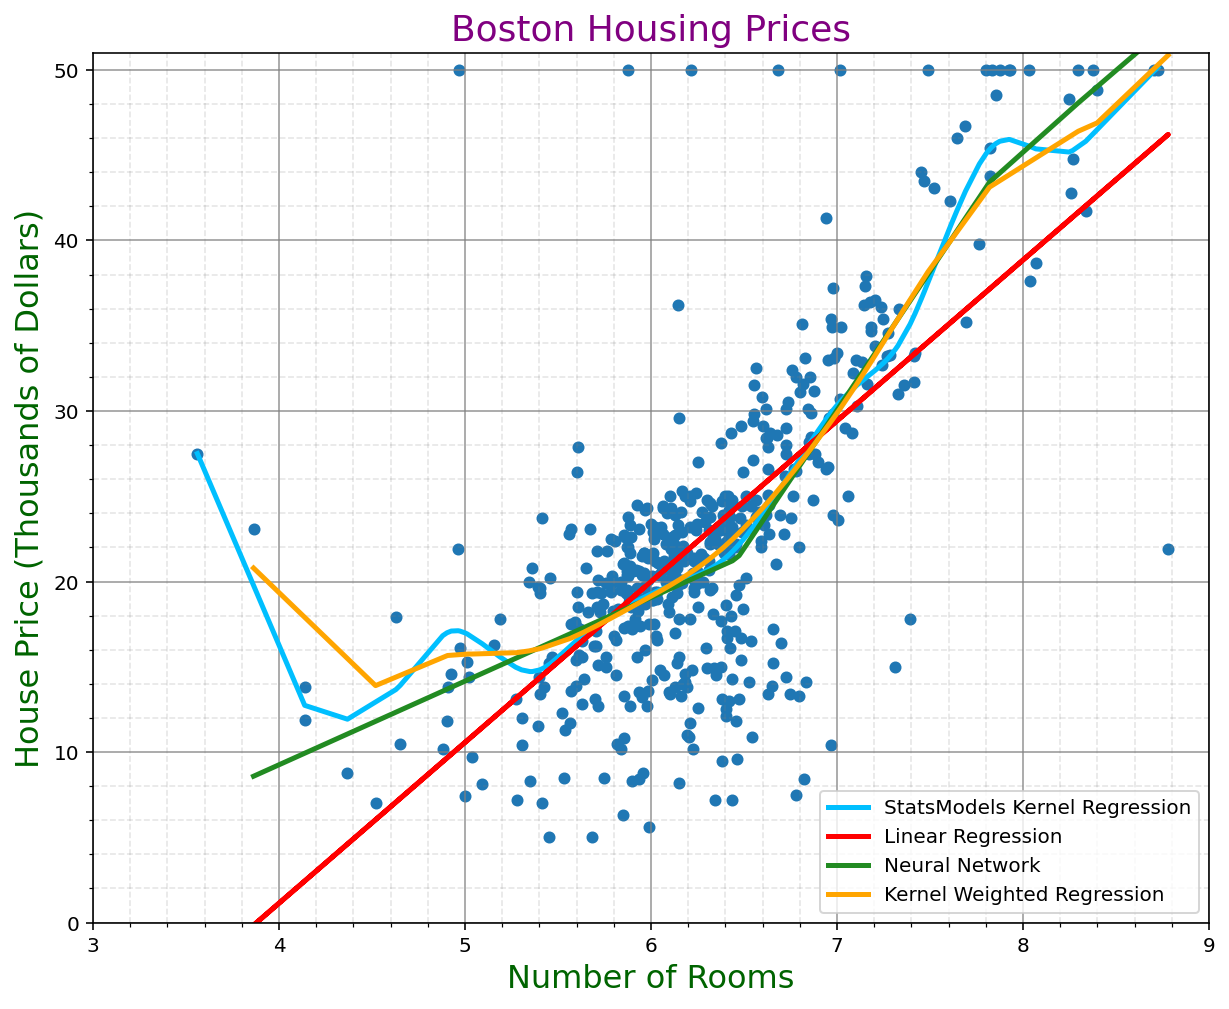

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.plot(dat_train[:,0],yhat_sm,color='deepskyblue',lw=2.5,label='StatsModels Kernel Regression')
ax.plot(X_test, lm.predict(X_test), color='red',lw=2.5,label='Linear Regression')
ax.plot(dat_test[:,0], yhat_nn, color='forestgreen',lw=2.5,label='Neural Network')
ax.plot(dat_test[:,0], model_lowess(dat_train,dat_test,Quartic,0.45), color='orange',lw=2.5,label='Kernel Weighted Regression')
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.legend()
plt.show()

In [53]:
yhat_sm_test, y_std = model_KernReg.fit(dat_test[:,0])

In [54]:
mae_sm = mean_absolute_error(dat_test[:,1], yhat_sm_test)
print("MAE StatsModels Kernel Regression = ${:,.2f}".format(1000*mae_sm))

MAE StatsModels Kernel Regression = $3,890.71


## Multivariate Models

In general we want

$$ \mathbb{E}(y):=F(x_1,x_2,x_3,...x_n)$$

where $F$ represents the model (regressor) we consider.

### Variable Selection

- We want to select only the features that are really important for our model.

- If the functional input-output model is $Y = F(X_1,X_2,X_3,X_4,X_5...X_p)$ then we imagine that it is very possible that only a subset of the variables $X_1,X_2,X_3,X_4,X_5...X_p$ are important and we need to disconsider (eliminate from the model) those that are not relevant.

- Programming and algorithms are based on equations, functions and statement evaluations.

- To represent variable selection in a functional way, we can think of multiplying each variable from the model by a binary weight, a weight of $0$ means the feature is not important and a weight of $1$ means that it is important:

$$
Y = F(w_1*X_1,w_2*X_2,w_3*X_3,w_4*X_4,w_5*X_5...w_p*X_p)
$$

where the weights $w_i$ are either $0$ or $1.$

The vector of binary weights $w=(w_1,w_2,w_3,...w_p)$ gives us what we call the ***sparsity pattern*** for the variable selection.